In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt


# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

# 导入模型
from src.Bayesian_recon import *

In [2]:
import src.Bayesian_recon.problems.model as model
from src.Bayesian_recon.problems.model import StandardModel as Model

import src.Bayesian_recon.problems.config as config
from src.Bayesian_recon.problems.config import config_fgt

from src.Bayesian_recon.problems import *

In [7]:
from src.Bayesian_recon.utils.fit import FitOptimizer
module_config = {"cluster": (PartitionCluster, 
                                {"transition_spec":[("entropy_1", "top_posterior"), 
                                                    (5, "ksimilar_centers"), 
                                                    (3, "random")]}),
                 "memory": (BaseMemory, {"param_resolution": 2})}
optimizer = FitOptimizer(module_config, 2)
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

Error initializing module cluster: 'FitOptimizer' object has no attribute 'partition_model'


In [12]:
res = optimizer.optimize_params_with_subs_parallel(
    config_fgt,
    [1,4]
)

Processing tasks: 100%|███████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/it]


In [6]:
subjects = list(learning_data.groupby('iSub'))
subject_data_map = {iSub: df for iSub, df in subjects}

subject_data = subject_data_map[1]
condition = subject_data['condition'].iloc[0]

s_data = (
    subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
    subject_data["choice"].values,
    subject_data["feedback"].values, 
    subject_data["category"].values
)
module_config = {"cluster": (PartitionCluster, 
                                {"transition_spec":[("entropy_1", "top_posterior"), 
                                                    (5, "ksimilar_centers"), 
                                                    (3, "random")]}),
                 "memory": (BaseMemory, {"param_resolution": 2})}
model = Model(config_fgt, module_config=module_config, condition=condition)

In [18]:
res['grid_errors']

{(np.float64(0.05), np.float64(0.00375)): np.float64(0.2174584006046831)}

In [4]:
def process_single_task(iSub, subject_data, gamma, w0, config, **kwargs):
    condition = subject_data['condition'].iloc[0]

    s_data = (
        subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
        subject_data["choice"].values,
        subject_data["feedback"].values, 
        subject_data["category"].values
    )
    module_config = {"cluster": (PartitionCluster, 
                                 {"transition_spec":[("entropy_1", "top_posterior"), 
                                                     (5, "ksimilar_centers"), 
                                                     (3, "random")]})}
    model_fgt = Model(config, module_config=module_config, condition=condition)

    # 做单次计算（在 forget.py 里写好的方法）
    step_results, mean_error = model_fgt.compute_error_for_params(s_data, gamma, w0, **kwargs)
    
    return iSub, gamma, w0, mean_error, step_results

In [5]:
def parallel_processing(learning_data, config, gamma_values, w0_values, n_jobs):
    """
    将 (被试, gamma, w0) 拆分为最小任务并行计算。
    最终只保存：
      - best_params: (gamma, w0) 最优组合
      - best_error
      - best_step_results (仅最优组合对应的 step 级结果)
      - grid_errors: 一个 dict, key=(gamma,w0), value=error，用于查看各组合的误差
    """
    # 1) 按被试分组
    subjects = list(learning_data.groupby('iSub'))
    subject_data_map = {iSub: df for iSub, df in subjects}

    # 2) 枚举全部 (iSub, gamma, w0)
    tasks = []
    for iSub, df in subjects:
        for gamma in gamma_values:
            for w0 in w0_values:
                tasks.append((iSub, gamma, w0))

    # 3) 并行执行
    
    results = Parallel(n_jobs=n_jobs, batch_size=1)(
        delayed(process_single_task)(
            iSub,
            subject_data_map[iSub],
            gamma,
            w0,
            config,
            cluster_prototype_amount=1,
            cluster_kwargs={"cluster_hypo_method":"random",
                            "proto_hypo_method":"random"}         
        )
        for (iSub, gamma, w0) in tqdm(tasks, desc="Fitting (subject, gamma, w0)")
    )

    
    # results 是个列表，元素形式为: (iSub, gamma, w0, mean_error, step_results)

    # 4) 把结果收集到数据结构里
    #    subject_grid_errors 用来记录对每个被试的 {(gamma, w0): error}
    #    subject_best_combo 临时记录每个被试最优组合的 (gamma, w0, error, step_results)
    subject_grid_errors = defaultdict(dict)
    subject_best_combo = {}

    for iSub, gamma, w0, err, step_res in results:
        # 4.1 记录 grid_errors
        subject_grid_errors[iSub][(gamma, w0)] = err

        # 4.2 查看是否是当前最优，如果是，就更新 best
        if iSub not in subject_best_combo:
            subject_best_combo[iSub] = (gamma, w0, err, step_res)
        else:
            _, _, best_err, _ = subject_best_combo[iSub]
            if err < best_err:
                subject_best_combo[iSub] = (gamma, w0, err, step_res)

    # 5) 最终返回的数据
    fitting_results = {}
    for iSub in subject_grid_errors.keys():
        best_gamma, best_w0, best_error, best_step_results = subject_best_combo[iSub]
        # grid_errors 这里就是简单地存 {(gamma, w0): error}
        fitting_results[iSub] = {
            "condition": subject_data_map[iSub]['condition'].iloc[0],
            "best_params": (best_gamma, best_w0),
            "best_error": best_error,
            "best_step_results": best_step_results,
            "grid_errors": subject_grid_errors[iSub]
        }

    return fitting_results

In [ ]:
if __name__ == '__main__':
    # 一般来说 gamma_values 和 w0_values 来自你在 forget.py 里设定的范围
    # 比如:
    gamma_values = np.linspace(0.05, 1, 20)
    # w0_values = np.linspace(0.00375, 0.075, 20)
    w0_values = [0.15/(i+1) for i in range(20)]
    
    fitting_results = parallel_processing(
        learning_data=learning_data,     # 你的完整DataFrame
        config=config_fgt,              # 之前定义好的config
        gamma_values=gamma_values,      # gamma搜索范围
        w0_values=w0_values,            # w0搜索范围
        n_jobs=100                      # 并行数，一般用CPU核数
    )

Fitting (subject, gamma, w0):   5%|▌         | 500/9600 [00:19<03:29, 43.35it/s]

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
os.makedirs(result_path, exist_ok=True)

joblib.dump(fitting_results, result_path / 'M_fgt_cluster_400.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/M_fgt_cluster_400.joblib']

In [6]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
fitting_results = joblib.load(result_path / 'M_fgt_cluster_400.joblib')

In [10]:
# 对比模型预测和实际数据
predict_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    # if iSub != 11:
    #     continue
    condition = subject_data['condition'].iloc[0]
    s_data = (subject_data[["feature1", "feature2", "feature3",
                            "feature4"]].values, subject_data["choice"].values,
              subject_data["feedback"].values, subject_data["category"].values)

    module_config = {
        "cluster": (PartitionCluster, {
            "transition_spec": [("entropy_1", "top_posterior"),
                                (5, "ksimilar_centers"), (3, "random")]
        })
    }
    model_fgt = Model(config, module_config=module_config, condition=condition)

    sub_results = fitting_results[iSub]
    # optimize_results = sub_results['optimize_results']
    best_step_results = sub_results['best_step_results']
    results = model_fgt.predict_choice(s_data,
                                       best_step_results,
                                       use_cached_dist=False,
                                       window_size=16)

    predict_results[iSub] = {
        'condition': condition,
        'true_acc': results['true_acc'],
        'pred_acc': results['pred_acc'],
        'sliding_true_acc': results['sliding_true_acc'],
        'sliding_pred_acc': results['sliding_pred_acc'],
        'sliding_pred_acc_std': results['sliding_pred_acc_std']
    }

In [15]:
# 导入模型分析
import src.Bayesian_recon.utils.model_evaluation_new as model_eval
importlib.reload(model_eval)
from src.Bayesian_recon.utils.model_evaluation_new import ModelEval

model_eval = ModelEval()

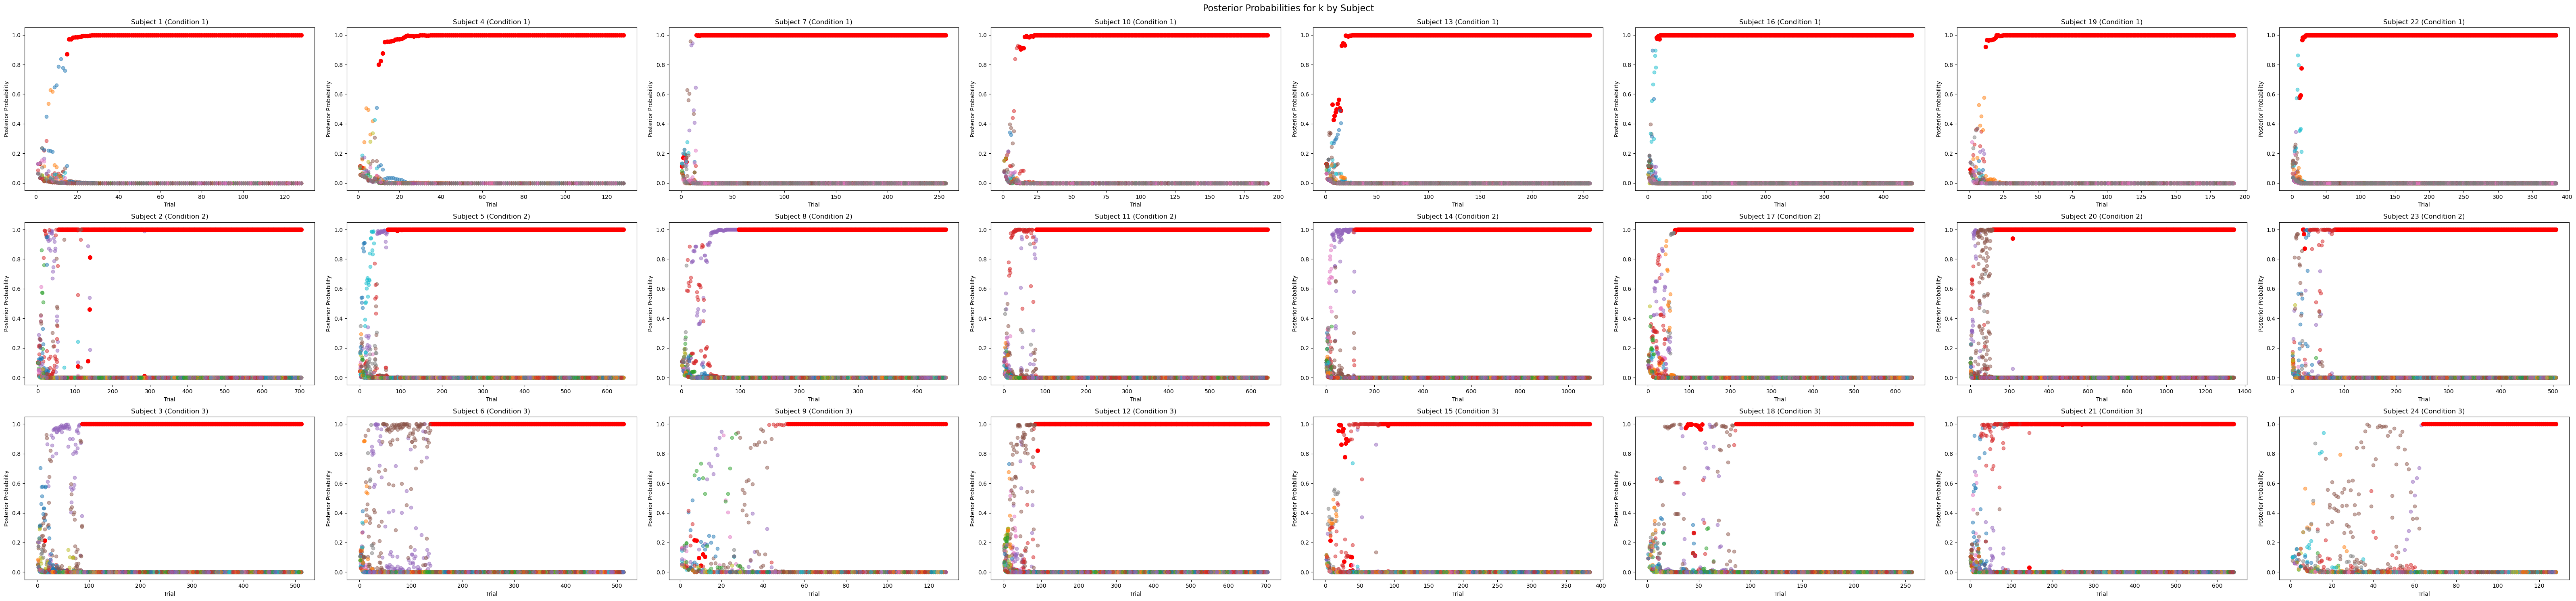

In [17]:
# 绘制最优参数变化图
# model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_fgt_cluster_400_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, limit=True, save_path=result_path / f'M_fgt_cluster_400_posteriors.png')

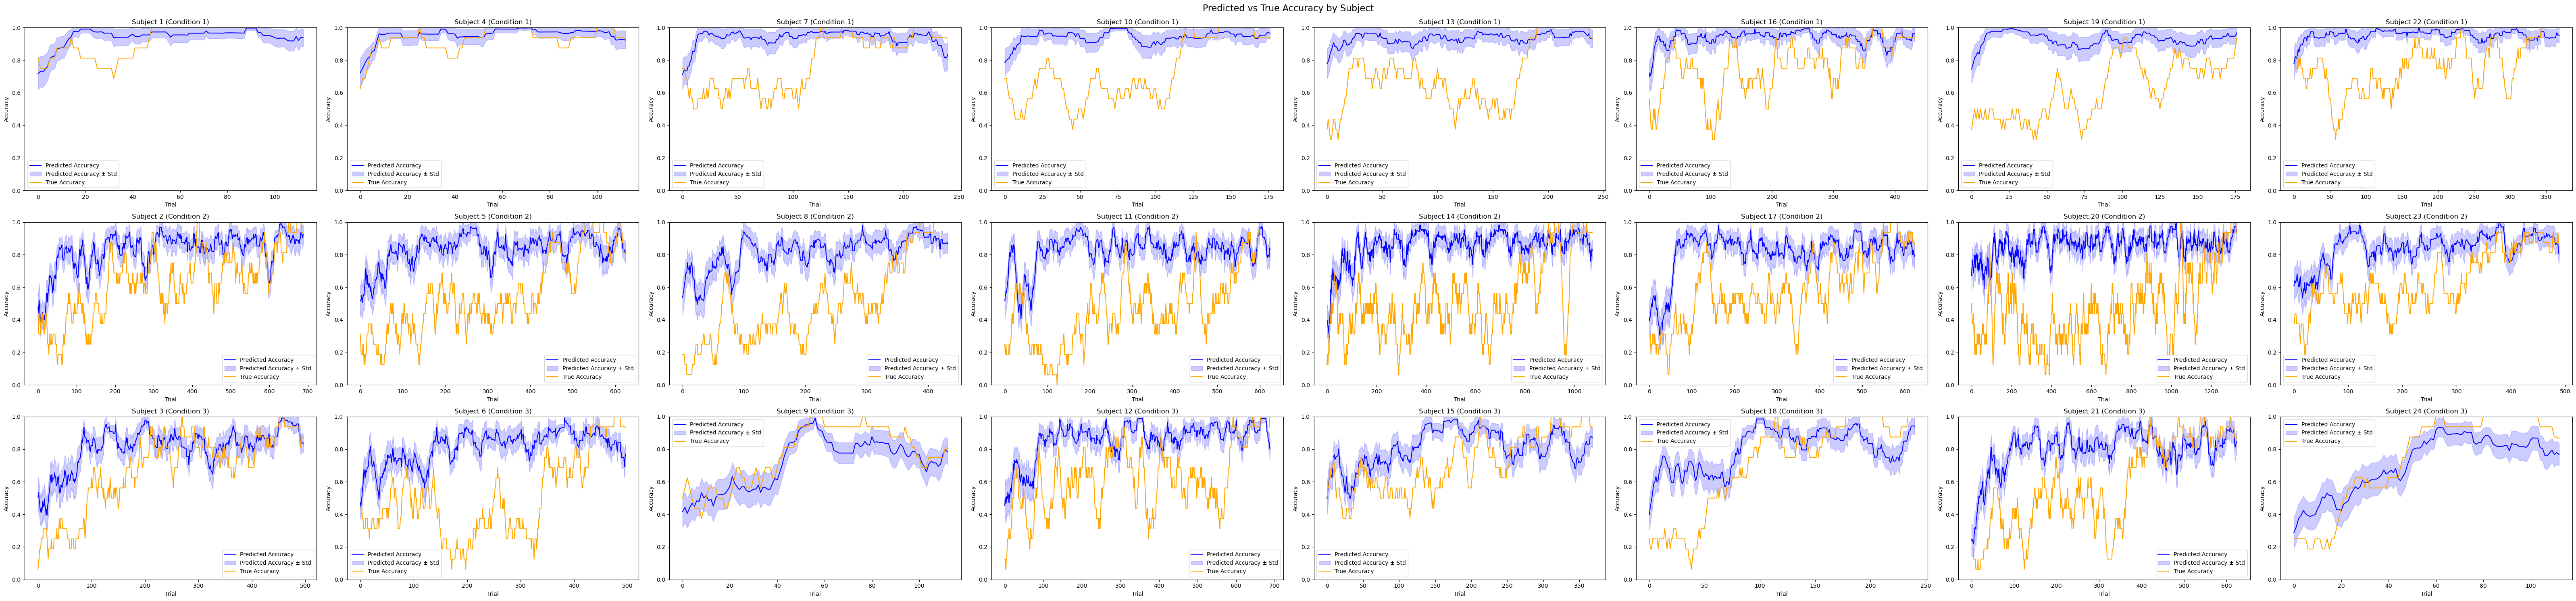

In [11]:
# 绘制模型预测和实际数据对比图
model_eval.plot_accuracy_comparison(predict_results, result_path / 'M_fgt_cluster_400_acc.png')

In [12]:
# 绘制error grid图
model_eval.plot_error_grids(fitting_results, result_path / f'M_fgt_cluster_400_errors.png')